In [132]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [133]:
from pathlib import Path

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from energySystem import System, NaturalGasBoiler, HeatPump, Battery, ThermalStorage, PVsystem, Windsystem, ElectricBoiler
import layouts.default_values as DEFAULT

In [134]:
sns.set_context(context="notebook")
plt.rcParams["figure.dpi"] = 300
path = Path('.') / "layouts"

## Import data

In [135]:
def get_demand_mask_and_price(df, colName, dt):
    col = df[colName].to_numpy() / dt
    mask = col > 0
    price = col[mask][0]
    return mask, price

In [136]:
##### loads
df = pd.read_csv(path / "loads" / "site1_load.csv")
dt = 1/4 # in hours
powerLoad, heatLoad = df['Power Load [kWh]'].to_numpy(), df['Heat Load [kWh]'].to_numpy()

##### prices
df = pd.read_csv(path / "power_grid" / "power_price_B20.csv")
energyPricePower = df["energyPrice"].to_numpy() # $/kWh
sellBackPrice = np.full(len(energyPricePower), DEFAULT.SELL_BACK_PRICE) # $/kWh
# from per kW to per kWh in 15 minutes
powerDemandFee = [get_demand_mask_and_price(df, colName, dt) for colName in ["peakDemandSummerPrice",
                                                                          "partialPeakDemandSummerPrice",
                                                                          "demandSummerPrice",
                                                                          "peakDemandWinterPrice",
                                                                          "demandWinterPrice"]]
df = pd.read_csv(path / "gas" / "gas_price.csv")
energyPriceGas = df["energyPrice"].to_numpy() # $/kWh

##### emissions
df = pd.read_csv(path / "power_grid" / "power_grid_emissions.csv")
df.ffill(inplace=True)
emissionsPower = df["MOER version 2.0"].to_numpy() # kCO2eq/KWhe
df = pd.read_csv(path / "gas" / "gas_emissions.csv")
emissionsGas = df["gasEmissions"].to_numpy() # kCO2eq/kWhgas

##### pv load
df = pd.read_csv(path / "renewable_loadprofiles" / "utility_scale_solar.csv")
pvuLoad = df["0"].to_numpy()

##### wind load
df = pd.read_csv(path / "renewable_loadprofiles" / "wind.csv")
windLoad = df["feedin_power_plant"].to_numpy()

##### time index
timeIndex = pd.date_range(start='1/1/2023', periods=len(powerLoad), freq='15min')

# clear memory
del df

In [137]:
# number of timesteps
n_timesteps = len(powerLoad)

In [138]:
system1 = System(
    "baseline",
    timeIndex=timeIndex,
    powerLoad=powerLoad,
    heatLoad=heatLoad,
    powerPrice=energyPricePower,
    sellBackPrice=sellBackPrice,
    powerDemandFee=powerDemandFee,
    gasPrice=energyPriceGas,
    gridMarginalEmissions=emissionsPower,
    gasMarginalEmissions=emissionsGas
)
ngf1 = NaturalGasBoiler(
    n_timesteps=n_timesteps,
    dt=1/4,
    eff=DEFAULT.GAS_BOILER_EFF,
    capacityPrice=DEFAULT.GAS_BOILER_CAPA_PRICE,
    discRate=DEFAULT.DISCOUNT_RATE,
    n_years=DEFAULT.GAS_BOILER_LIFETIME)
system1.addComponent(ngf1)


In [139]:
hp1 = HeatPump(
    n_timesteps=n_timesteps,
    dt=1/4,
    COP=DEFAULT.HP_COP,
    ramp_rate=DEFAULT.HP_RAMP_RATE,
    capacityPrice=DEFAULT.HP_CAPA_PRICE,
    discRate=DEFAULT.DISCOUNT_RATE,
    n_years=DEFAULT.HP_LIFETIME
)
system1.addComponent(hp1)

In [140]:
lion1 = Battery(
    n_timesteps=n_timesteps,
    dt=1/4,
    capacityPrice=DEFAULT.LION_CAPA_PRICE,
    maxChargeRate=DEFAULT.LION_MAX_CHARGE_RATE,
    effCharge=DEFAULT.LION_EFF_CHARGE,
    effDischarge=DEFAULT.LION_EFF_DISCHARGE,
    discRate=DEFAULT.DISCOUNT_RATE,
    n_years=DEFAULT.LION_LIFETIME,
    name="Lithium Ion Battery"
)
system1.addComponent(lion1)

In [141]:
tes1 = ThermalStorage(
    n_timesteps=n_timesteps,
    dt=1/4,
    energyCapacityPrice=DEFAULT.TES_ECAPA_PRICE,
    powerCapacityPrice=DEFAULT.TES_PCAPA_PRICE,
    lossRate=DEFAULT.TES_LOSS_RATE,
    effCharge=DEFAULT.TES_EFF_CHARGE,
    effDischarge=DEFAULT.TES_EFF_DISCHARGE,
    discRate=DEFAULT.DISCOUNT_RATE,
    n_years=DEFAULT.TES_LIFETIME
)
system1.addComponent(tes1)

In [142]:
pvu1 = PVsystem(
    n_timesteps=n_timesteps,
    dt=1/4,
    pvLoadProfile=pvuLoad,
    ppaPrice=DEFAULT.PV_OFFSITE_PPA_PRICE,
    onsite=False
)
system1.addComponent(pvu1)

In [143]:
wind1 = Windsystem(
    n_timesteps=n_timesteps,
    dt=1/4,
    WindLoadProfile=windLoad,
    ppaPrice=DEFAULT.WIND_OFFSITE_PPA_PRICE,
    onsite=False
)
system1.addComponent(wind1)

In [144]:
elecboil1 = ElectricBoiler(
    n_timesteps=n_timesteps,
    dt=1/4,
    eff=DEFAULT.ELECTRIC_BOILER_EFF,
    capacityPrice=DEFAULT.ELECTRIC_BOILER_CAPA_PRICE,
    discRate=DEFAULT.DISCOUNT_RATE,
    n_years=DEFAULT.ELECTRIC_BOILER_LIFETIME
)
system1.addComponent(elecboil1)

## Sensitivity Analysis

In [152]:
problem = system1.getModel(objective="cost")
costs = []
capaPrice0 = DEFAULT.HP_CAPA_PRICE
capaPrices = capaPrice0 * (1 + np.arange(-10, 11, 1)/100)
for capaPrice in capaPrices:
     hp1._parameters['capacityPrice'].value = capaPrice
     problem.solve(solver="MOSEK")
     print(f"capacityPrice: {np.round(capaPrice)} $/kW, status: {problem.status}, cost: {np.round(problem.value/1e6, 3)} M$")
     costs.append(problem.value)

capacityPrice: 630.0 $/kW, status: optimal, cost: 2.477 M$
capacityPrice: 637.0 $/kW, status: optimal, cost: 2.479 M$
capacityPrice: 644.0 $/kW, status: optimal, cost: 2.481 M$
capacityPrice: 651.0 $/kW, status: optimal, cost: 2.484 M$
capacityPrice: 658.0 $/kW, status: optimal, cost: 2.486 M$
capacityPrice: 665.0 $/kW, status: optimal, cost: 2.488 M$
capacityPrice: 672.0 $/kW, status: optimal, cost: 2.49 M$
capacityPrice: 679.0 $/kW, status: optimal, cost: 2.492 M$
capacityPrice: 686.0 $/kW, status: optimal, cost: 2.495 M$
capacityPrice: 693.0 $/kW, status: optimal, cost: 2.497 M$
capacityPrice: 700.0 $/kW, status: optimal, cost: 2.499 M$
capacityPrice: 707.0 $/kW, status: optimal, cost: 2.501 M$
capacityPrice: 714.0 $/kW, status: optimal, cost: 2.503 M$
capacityPrice: 721.0 $/kW, status: optimal, cost: 2.505 M$
capacityPrice: 728.0 $/kW, status: optimal, cost: 2.507 M$
capacityPrice: 735.0 $/kW, status: optimal, cost: 2.509 M$
capacityPrice: 742.0 $/kW, status: optimal, cost: 2.511 M

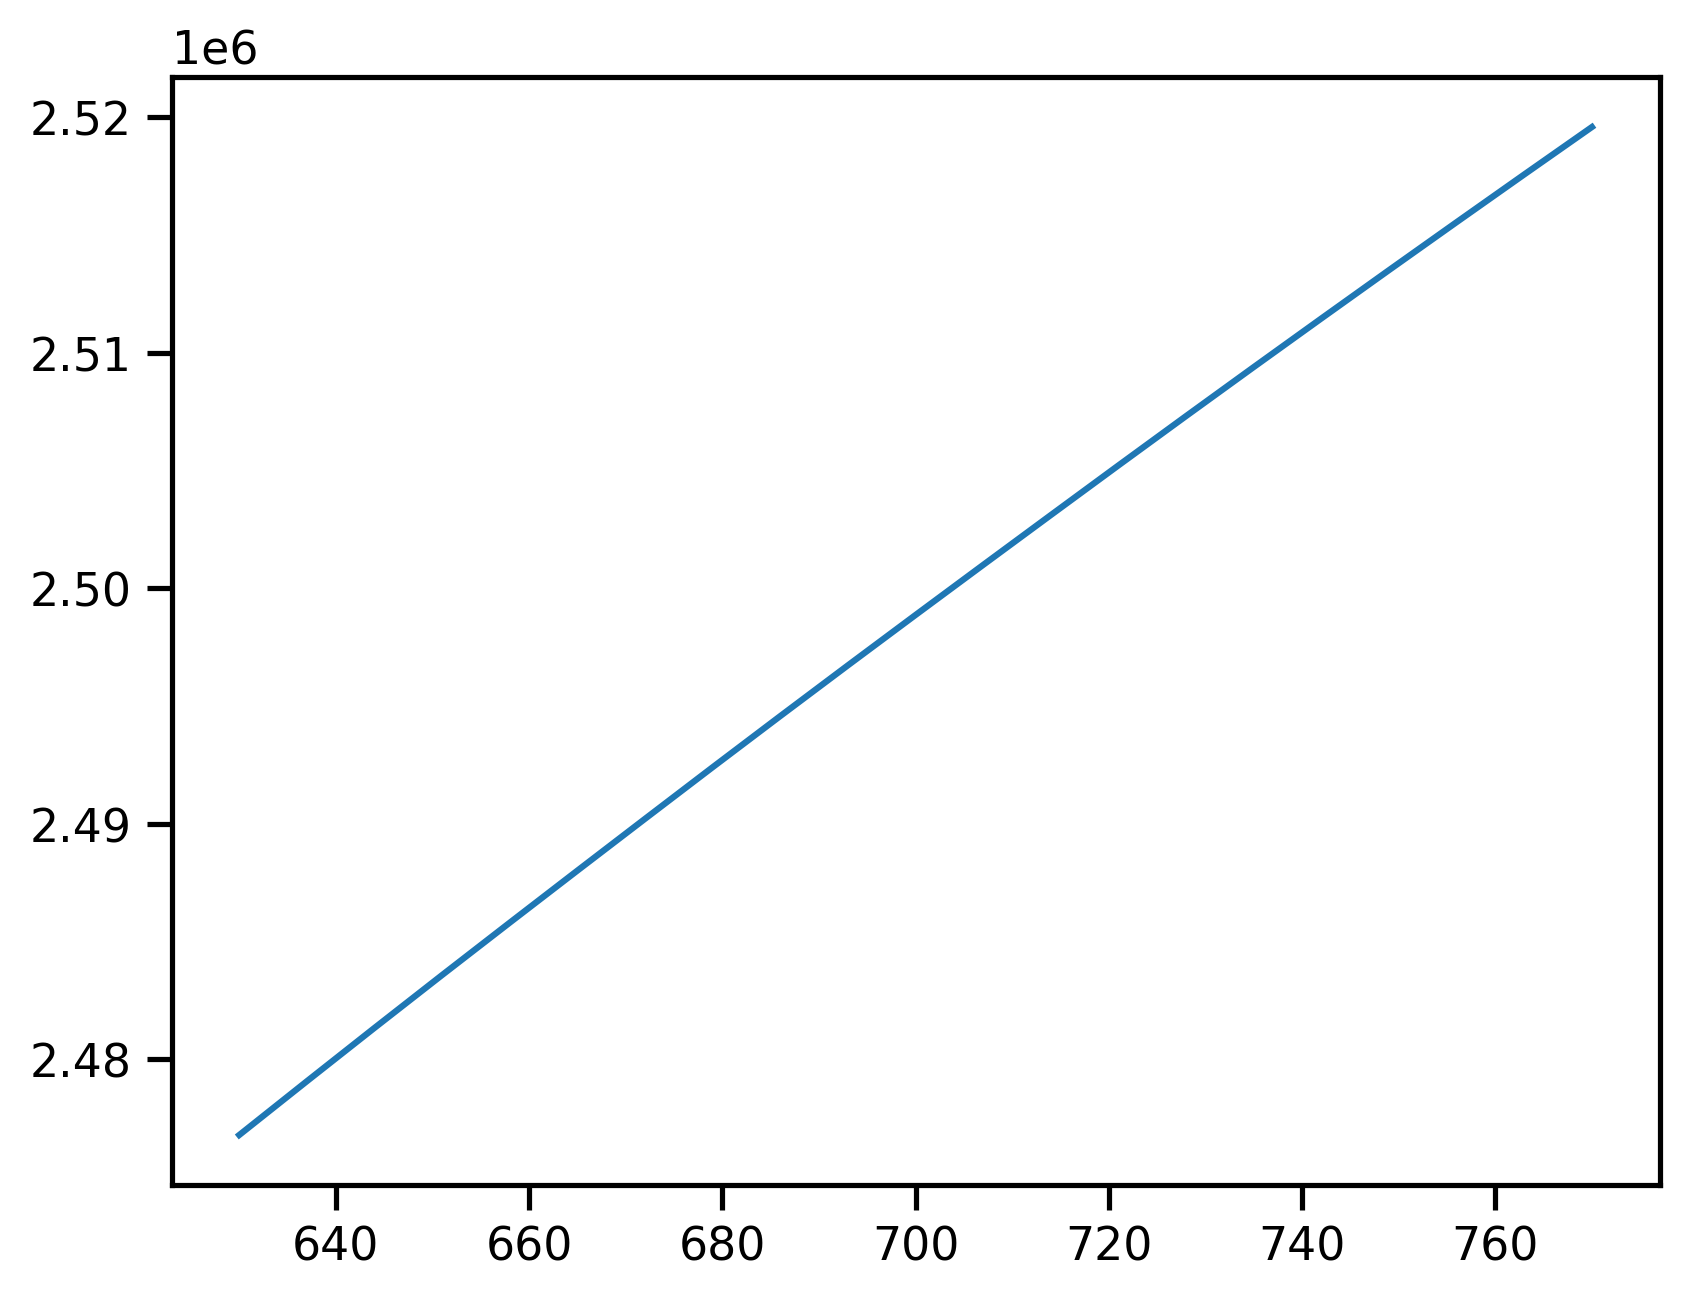

In [153]:
capaPrices = capaPrice0 * (1 + np.arange(-10, 11, 1)/100)
plt.plot(capaPrices, costs);